### Evaluate Clustering

In [1]:
import sys
sys.path.append('../pcqc')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pcqc import *

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import scanpy as sc
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from kruskal_best_pcs import *

In [4]:
import os

In [5]:
#translate cluster labels to groundtruth labels
from sklearn.tree import DecisionTreeClassifier

In [6]:
#can also include clustering metrics too
#pro: dont want to favor highly fragmented clusterings
#con: a highly fragmented clustering isnt necessarily bad
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.metrics import average_precision_score, recall_score

In [7]:
from sklearn.naive_bayes import MultinomialNB

In [8]:
output_plots = 'plots/cluster_plots.pdf'
plot_dictionary = dict()

## From PC Selection Notebook
1. For Kruskal PCQC Test, use threshold 1e-50
2. For PCQC, select top 15 PCs
3. The cut off for scree plot with traditional methods is between 14 and 17.

__Notes__
1. Weighted Accuracy (using the score method)
2. Log Loss (also weighted)
3. Average Precision Score! See https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data for a definition.
4. ROC_AUC_Score is really high and can't recommend it at this time.
5. Issue: Ordering decision tree (who is classified first can affect prediction performance) may be awkward.  Random Forest could be a good alternative.  
6. __Multinomial Naive Bayes__ might be better where we only have ONE multinomial distribution with one coin flip.  (Rows add up to 1.  Rolling a die once).  Use inverse frequency prior to balance class sizes.  X is simply your dummy cluster matrix.  
7. __Saving our Clusterings__ Save clusterings (probabilities) and response from each sim and put it in a sep file/directory based on parameters.
8. __One vs One__ From the probabilities, taking two columns (and selecting the rows whose response corresponds to those two columns) - reduces it to a one vs one problem.  Can look at the min or largest change in OvO to get a nice interpretation.
9. __Confusion Matrices__ Plotting the confusion matrix of the median (or a kind of pair plot from the OvO might help add interpretation.)

### Import Data

In [9]:
ground_truth = pd.read_csv('ground_truth.csv')

In [10]:
ground_truth.head()

,Unnamed: 0,CD3,CD4,CD8,CD45RA,CD56,CD16,CD11c,CD14,CD19,CD34,leiden,count,truth_names
0,CTGTTTACACCGCTAG,-0.735049,-0.843184,-0.060869,-0.881426,0.139739,1.011129,-0.285084,-0.397836,0.191633,2.378932,4,1,Mouse/CD34+
1,CTCTACGGTGTGGCTC,-0.780484,-0.965256,-0.198995,0.456681,0.208088,0.443042,-0.385237,-0.833485,3.403329,0.785726,6,1,B
2,AGCAGCCAGGCTCATT,-0.583873,-0.653746,-0.181778,-0.813562,0.503768,0.560597,-0.385237,-0.596925,0.321402,0.763879,4,1,Mouse/CD34+
3,GAATAAGAGATCCCAT,-0.763236,-0.873997,-0.225356,-1.015237,0.032542,0.116402,-0.582256,-0.790293,-0.153276,0.871379,4,1,Mouse/CD34+
4,GTGCATAGTCATGCAT,-0.718461,-0.803147,0.068072,-0.837305,0.735209,1.074611,-0.170130,-0.625199,0.349014,2.033236,4,1,Mouse/CD34+


### Get Polished Data

In [11]:
cbmc_df = pd.read_csv('data/filtered_cbmc_assay.csv')
cbmc_df.index = cbmc_df['Unnamed: 0']
cbmc_df.drop(columns = 'Unnamed: 0',inplace = True)
cbmc_df = cbmc_df.transpose()
cbmc_df.head()

Unnamed: 0,A4GALT,ABCB10,ABCC3,ABCG2,ABI3,AC002454.1,AC004381.6,AC004791.2,AC005339.2,AC005356.1,...,MOUSE-Rtn4,MOUSE-Ppp1ca,MOUSE-Cald1,MOUSE-Rps26,MOUSE-Ctsl,MOUSE-Tnfrsf12a,MOUSE-Esd,MOUSE-Acta2,MOUSE-Arpc2,MOUSE-Calr
CTGTTTACACCGCTAG,-0.043005,-0.127965,-0.089527,-0.044218,-0.31871,-0.077685,-0.067245,-0.026909,-0.020008,-0.02334,...,3.666522,2.806501,4.390655,2.338495,4.236169,3.291269,3.338256,1.181500,3.575336,2.491014
CTCTACGGTGTGGCTC,-0.043005,-0.127965,-0.089527,-0.044218,-0.31871,-0.077685,-0.067245,-0.026909,-0.020008,-0.02334,...,3.431149,3.219714,3.572171,3.176395,3.501385,3.099354,3.375631,3.738814,3.165883,2.803176
AGCAGCCAGGCTCATT,-0.043005,-0.127965,-0.089527,-0.044218,-0.31871,-0.077685,-0.067245,-0.026909,-0.020008,-0.02334,...,3.810213,3.309678,3.658060,3.236889,3.957931,3.465798,2.787275,2.762576,3.510315,3.762173
GAATAAGAGATCCCAT,-0.043005,-0.127965,-0.089527,-0.044218,-0.31871,-0.077685,-0.067245,-0.026909,-0.020008,-0.02334,...,3.686728,3.248412,3.565898,3.485953,3.325856,2.842990,3.483046,2.815389,3.319044,4.037947
GTGCATAGTCATGCAT,-0.043005,-0.127965,-0.089527,-0.044218,-0.31871,-0.077685,-0.067245,-0.026909,-0.020008,-0.02334,...,3.561990,3.678177,4.183636,3.325419,2.450436,2.636636,1.886444,6.334562,3.971224,2.929176


In [12]:
def prob_confusion_matrix(probs,ground_truth):
    #probabilistic confusion matrix that enforces balanced class sizes
    df = pd.DataFrame(probs)
    df['clusters'] = ground_truth
    confusion_matrix = df.groupby('clusters').mean()
    return confusion_matrix

In [13]:
def compute_model_loss(X,y,weights):
    dummies_y = pd.get_dummies(y).values
    Bayes = MultinomialNB(fit_prior = False)
    Bayes.fit(X,y)
    predictions = Bayes.predict_proba(X)
    loglo = log_loss(y, predictions, sample_weight = weights)
    aps = average_precision_score(dummies_y, predictions, average = 'macro')
    weighted_accuracy = Bayes.score(X,y,sample_weight = weights)
    metrics = {'log_loss':loglo,'average_precision_score': aps,
               'weighted_accuracy':weighted_accuracy}
    return predictions, metrics

In [14]:
def compute_log_loss_by_class(predictions,y):
    output = []
    unique_values = np.unique(y)
    for response in unique_values:
        filtered_rows = np.where(y == response)[0]
        subset_log_loss = log_loss(y[filtered_rows], predictions[filtered_rows,:], labels = unique_values)
        output.append(subset_log_loss)
    return output

In [15]:
#make sure adata contains only vars you want to use
#df_stats needs to be initialized
def data_sim(adata, sim_name, df_stats, ground_truth, res_params = np.arange(.4,2,.4), 
             n_neighbor_params = np.arange(10,30,5), trials = 20, random_state_start = 0, save = False,
            n_pcs = None, use_rep = None, save_directory = ''):
    random_state = random_state_start
    index = df_stats.shape[0]
    y = ground_truth['leiden']
    unique_values = np.unique(y)
    weights = ground_truth.groupby('leiden')['count'].transform(lambda x: 1/x.count()).values
    #create new directory to save results
    directory = save_directory + '/' + sim_name
    if save:
        os.mkdir(directory)
        
    for n_neighbors in n_neighbor_params:
        sc.pp.neighbors(adata,n_neighbors = n_neighbors, use_rep = use_rep, n_pcs = n_pcs)
        for res_param in res_params:
            for trial in range(trials):
                print('Trial: ' + str(np.round(trial,2)) + ' Res: ' + str(np.round(res_param,2)) + ' Nbrs: ' + str(np.round(n_neighbors,2)) + '   ', 
                      end = '\r')
                #compute simulation with metrics
                sc.tl.leiden(adata, resolution = res_param, random_state = random_state)
                X = pd.get_dummies(adata.obs['leiden'])
                predictions, metrics = compute_model_loss(X,y,weights)
                submetrics = compute_log_loss_by_class(predictions,y)
                new_row = [sim_name, trial, res_param, n_neighbors, 
                                       metrics['log_loss'], metrics['average_precision_score'],
                                      metrics['weighted_accuracy']] + submetrics
                
                df_stats.loc[index] = new_row
                
                #if we want to save the predictions
                if save:
                    file_location = directory + '/' + 'res_' + str(res_param) + 'n_nbrs_' + str(n_neighbors) \
                                + 'trial_' + str(trial) + '.npy'
                    np.save(file_location,predictions)
                    
                index += 1
                random_state += 1
    return df_stats
                
                #save predictions

### Run Traditional PCA

In [16]:
adata = sc.AnnData(X = cbmc_df.values)
sc.tl.pca(adata,n_comps = 100)

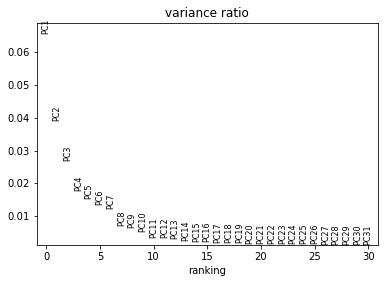

In [17]:
sc.pl.pca_variance_ratio(adata)

In [18]:
columns = ['name', 'trial', 'resolution', 'n_neighbors', 'log_loss','aps','weighted_accuracy']
for value in np.unique(ground_truth['leiden']):
    columns.append('log_loss_cluster_' + str(value))

df_stats = pd.DataFrame(columns = columns)

### Simulations to Do:
* [x] Top 31 Permutation (Pvalue)
* [x] Top 24 Permutation (Significant)
* [x] Top 16 (Scree Plot)
* [x] Top 40,70,100 (Illustration choosing too many PCs)
* [ ] PCQC-90 Top 14
* [ ] PCQC-95 Top 18
* [ ] Kruskal-Wallis?

In [19]:
df_stats = data_sim(adata, 'PC_Permutation_Pvalue', df_stats, ground_truth, random_state_start = 300, n_pcs = 31)

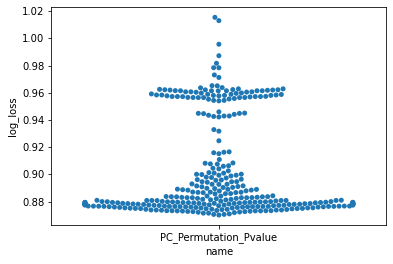

In [20]:
sns.swarmplot(x = 'name', y = 'log_loss', data = df_stats)

In [21]:
df_stats.groupby(by = ['name']).mean()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_0,log_loss_cluster_1,log_loss_cluster_2,log_loss_cluster_3,log_loss_cluster_4,log_loss_cluster_5,log_loss_cluster_6,log_loss_cluster_7,log_loss_cluster_8,log_loss_cluster_9,log_loss_cluster_10,log_loss_cluster_11,log_loss_cluster_12,log_loss_cluster_13
name,,,,,,,,,,,,,,,,,,
PC_Permutation_Pvalue,1.0,0.902512,0.608291,0.660514,0.759952,1.273305,1.293797,0.388347,0.744558,1.591587,0.832746,1.377758,0.719551,0.424789,1.211437,0.332651,0.268788,1.415902


In [22]:
df_stats = data_sim(adata, 'PC_Permutation_Ratio', df_stats, ground_truth, random_state_start = 300, n_pcs = 24)

In [23]:
df_stats = data_sim(adata, 'PC_Scree', df_stats, ground_truth, random_state_start = 300, n_pcs = 16)

In [24]:
#for n_pcs in [15,20,40,60,80]:
for n_pcs in [40,70,100]:
    name = 'PCs_' + str(n_pcs)
    df_stats = data_sim(adata, name, df_stats, ground_truth, random_state_start = 0, n_pcs = n_pcs)

In [26]:
df_stats['name'].unique()

array(['PC_Permutation_Pvalue', 'PC_Permutation_Ratio', 'PC_Scree',
       'PCs_40', 'PCs_70', 'PCs_100'], dtype=object)

In [27]:
#seeing improvements in clusters 8,9.
df_stats.groupby(by = ['name']).mean()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_0,log_loss_cluster_1,log_loss_cluster_2,log_loss_cluster_3,log_loss_cluster_4,log_loss_cluster_5,log_loss_cluster_6,log_loss_cluster_7,log_loss_cluster_8,log_loss_cluster_9,log_loss_cluster_10,log_loss_cluster_11,log_loss_cluster_12,log_loss_cluster_13
name,,,,,,,,,,,,,,,,,,
PC_Permutation_Pvalue,1.0,0.902512,0.608291,0.660514,0.759952,1.273305,1.293797,0.388347,0.744558,1.591587,0.832746,1.377758,0.719551,0.424789,1.211437,0.332651,0.268788,1.415902
PC_Permutation_Ratio,1.0,0.898509,0.607445,0.662653,0.780264,1.276970,1.295990,0.389939,0.743991,1.597304,0.821292,1.336369,0.749502,0.416276,1.157952,0.332180,0.262357,1.418746
PC_Scree,1.0,0.980869,0.560342,0.625213,0.801711,1.439102,1.466652,0.367311,0.746426,1.735486,0.829910,1.351682,1.459958,0.401565,1.153402,0.340036,0.264023,1.374898
PCs_100,1.0,1.007240,0.548160,0.604832,1.016948,1.323509,1.364598,0.390577,0.774573,1.637143,0.846093,1.567744,1.061347,0.524862,1.388094,0.389571,0.280019,1.536283
PCs_40,1.0,0.925870,0.597455,0.648371,0.835458,1.283848,1.294467,0.383451,0.740297,1.600763,0.816839,1.433178,0.742740,0.477667,1.232861,0.339109,0.267749,1.513755
PCs_70,1.0,0.976626,0.568003,0.618654,0.938024,1.319824,1.344443,0.380243,0.759317,1.623582,0.832306,1.497163,0.995360,0.537043,1.300334,0.356052,0.260702,1.528370


### Run pcqc: quantile

In [28]:
#this should probably happen earlier
pca = PC_Cluster(n_pcs = 100)
pca.fit(cbmc_df.values)
pca.norm_eigenvalues[0:20]

array([0.06562919, 0.03916874, 0.02691411, 0.01778673, 0.01531372,
       0.01340929, 0.01227411, 0.0069056 , 0.00643235, 0.00514619,
       0.00342394, 0.00324247, 0.00302587, 0.00232158, 0.00222412,
       0.00214154, 0.001905  , 0.00181226, 0.00176268, 0.00166096])

In [29]:
pca.pc_distribution()
pca.df_pca_dist.head()

,PC_Dist_0,PC_Dist_1,PC_Dist_2,PC_Dist_3,PC_Dist_4,PC_Dist_5,PC_Dist_6,PC_Dist_7,PC_Dist_8,PC_Dist_9,...,PC_Dist_90,PC_Dist_91,PC_Dist_92,PC_Dist_93,PC_Dist_94,PC_Dist_95,PC_Dist_96,PC_Dist_97,PC_Dist_98,PC_Dist_99
0,0.000109,1.017151e-06,3.472080e-08,1.432048e-08,5.050533e-09,1.319299e-07,4.266750e-08,2.720950e-08,2.365754e-10,3.106800e-08,...,2.198981e-09,1.751499e-08,2.922613e-11,2.244439e-09,5.922574e-09,1.228976e-08,4.705107e-09,1.509249e-09,1.960247e-09,2.843155e-09
1,0.000106,1.330582e-06,4.509797e-07,9.829682e-10,4.407147e-08,1.592044e-06,2.385236e-07,3.358053e-08,5.075646e-09,1.728385e-08,...,9.969644e-10,2.087265e-09,8.196951e-09,2.109240e-09,4.168864e-08,2.796389e-08,5.889346e-11,5.691022e-09,1.084981e-09,4.350326e-09
2,0.000112,1.352623e-06,2.310197e-07,2.536909e-08,2.595612e-08,3.811017e-07,1.088577e-10,1.922921e-08,3.803947e-08,2.003366e-09,...,2.840543e-09,2.023886e-08,1.010993e-12,2.542236e-08,3.257220e-09,9.102833e-09,4.732683e-08,1.206457e-08,1.393310e-10,4.298715e-09
3,0.000108,1.341827e-06,1.159750e-07,2.082525e-08,2.928377e-08,4.010636e-07,3.102027e-10,6.158710e-09,1.380496e-10,7.409330e-13,...,1.377265e-08,3.063582e-10,5.103592e-09,2.295113e-09,9.564528e-09,4.424484e-10,3.092323e-09,7.237929e-09,1.433666e-08,2.075092e-10
4,0.000102,9.337392e-07,2.459761e-07,2.138715e-10,6.602527e-08,2.070620e-07,1.215814e-10,2.952202e-09,2.365325e-08,2.340283e-08,...,2.689249e-10,4.261099e-09,5.340679e-09,1.173059e-08,2.289973e-08,2.751366e-09,2.644236e-08,4.734207e-08,2.013404e-09,4.568171e-09


In [30]:
pca.pc_stats()

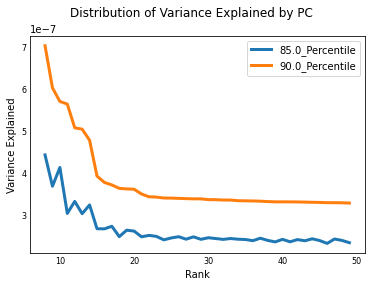

In [31]:
fig = sorted_dist_var_pc_plot(pca, rank = np.arange(8,50), sort_var = '90.0_Percentile', max_subset_size = 2)

In [38]:
pca.select_top_pcs(criteria = '90.0_Percentile', n_top_pcs = 14)
reduced_matrix = pca.use_top_pcs()

In [39]:
reduced_matrix.shape

(8617, 14)

In [40]:
adata_pcqc = sc.AnnData(X = reduced_matrix)

In [43]:
#df_stats.drop(columns = 'index', inplace = True)

In [44]:
df_stats = data_sim(adata_pcqc, 'PCQC_90_14Pcs', 
                    df_stats, ground_truth, random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [ ]:
#Run it for PCQC 95-18

In [45]:
pca.select_top_pcs(criteria = '95.0_Percentile', n_top_pcs = 18)
reduced_matrix = pca.use_top_pcs()
reduced_matrix.shape

(8617, 18)

In [46]:
adata_pcqc = sc.AnnData(X = reduced_matrix)
df_stats = data_sim(adata_pcqc, 'PCQC_95_18Pcs', 
                    df_stats, ground_truth, random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [47]:
df_stats.groupby(by = ['name']).mean()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_0,log_loss_cluster_1,log_loss_cluster_2,log_loss_cluster_3,log_loss_cluster_4,log_loss_cluster_5,log_loss_cluster_6,log_loss_cluster_7,log_loss_cluster_8,log_loss_cluster_9,log_loss_cluster_10,log_loss_cluster_11,log_loss_cluster_12,log_loss_cluster_13
name,,,,,,,,,,,,,,,,,,
PCQC_90_14Pcs,1.0,0.891592,0.603715,0.669201,0.753482,1.283496,1.319333,0.375805,0.731192,1.601467,0.819902,1.286113,0.744470,0.416877,1.097461,0.334782,0.289650,1.428261
PCQC_95_18Pcs,1.0,0.895443,0.607215,0.663993,0.751147,1.281483,1.304580,0.390114,0.767001,1.593838,0.819328,1.311722,0.743722,0.404778,1.131256,0.360621,0.262644,1.413964
PC_Permutation_Pvalue,1.0,0.902512,0.608291,0.660514,0.759952,1.273305,1.293797,0.388347,0.744558,1.591587,0.832746,1.377758,0.719551,0.424789,1.211437,0.332651,0.268788,1.415902
PC_Permutation_Ratio,1.0,0.898509,0.607445,0.662653,0.780264,1.276970,1.295990,0.389939,0.743991,1.597304,0.821292,1.336369,0.749502,0.416276,1.157952,0.332180,0.262357,1.418746
PC_Scree,1.0,0.980869,0.560342,0.625213,0.801711,1.439102,1.466652,0.367311,0.746426,1.735486,0.829910,1.351682,1.459958,0.401565,1.153402,0.340036,0.264023,1.374898
PCs_100,1.0,1.007240,0.548160,0.604832,1.016948,1.323509,1.364598,0.390577,0.774573,1.637143,0.846093,1.567744,1.061347,0.524862,1.388094,0.389571,0.280019,1.536283
PCs_40,1.0,0.925870,0.597455,0.648371,0.835458,1.283848,1.294467,0.383451,0.740297,1.600763,0.816839,1.433178,0.742740,0.477667,1.232861,0.339109,0.267749,1.513755
PCs_70,1.0,0.976626,0.568003,0.618654,0.938024,1.319824,1.344443,0.380243,0.759317,1.623582,0.832306,1.497163,0.995360,0.537043,1.300334,0.356052,0.260702,1.528370


### Run pcqc: clusters

In [54]:
pca.select_top_pcs(criteria = 'evalue', n_top_pcs = 100)

In [55]:
reduced_matrix = pca.use_top_pcs()

In [56]:
reduced_matrix.shape

(8617, 100)

In [57]:
def compute_best_pcs(reduced_matrix, n_neighbors, resolution, threshold = 1e-6, max_discard = 20):
    #max discard, max number of pcs that are discarded in a single round 
    df = pd.DataFrame(reduced_matrix)
    finished = False
    index = 0
    while not finished:
        adata = sc.AnnData(X = reduced_matrix)
        sc.pp.neighbors(adata, n_neighbors = n_neighbors, use_rep = 'X')
        sc.tl.leiden(adata, resolution = resolution, random_state = np.random.randint(100))
        df['Clusters'] = adata.obs['leiden'].values
        valid_cols = [col for col in df.columns if col != 'Clusters']
        kruskal_test, best_pcs = pc_kruskal_test(df,valid_cols, threshold = threshold)
        candidates_to_elim = np.where(np.array(kruskal_test) > threshold)
        #get max discard lowest values
        #print(kruskal_test)
        #print(candidates_to_elim)
        
        lowest_values = np.argsort(-1*np.array(kruskal_test))[0:max_discard]
        #print(lowest_values)
        to_discard = []
        for value in lowest_values:
            if kruskal_test[value] > threshold:
                to_discard.append(value)
        #print(to_discard)
        to_keep = [col for i,col in enumerate(df.columns) if i not in to_discard]
        if len(to_discard) == 0:
            finished = True
        else:
            df = df[to_keep]
            reduced_matrix = df.values
        
    return df,kruskal_test

In [58]:
reduced_df, kruskal = compute_best_pcs(reduced_matrix, 15, .8, threshold = 1e-50)

In [59]:
reduced_df.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         15,         16,         18,         19,
               20,         21,         24,         25, 'Clusters'],
      dtype='object')

In [60]:
kruskal

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.878743754538337e-198,
 9.341058675497834e-170,
 0.0,
 2.3583296061140882e-280,
 0.0,
 3.335443994781617e-117,
 2.8159803104304703e-210,
 4.78990580245745e-220,
 5.160221188037731e-162,
 4.122345417009408e-149]

In [61]:
reduced_df = reduced_df.drop(columns = 'Clusters')

In [62]:
reduced_df.shape

(8617, 22)

In [63]:
adata_pcqc_clusters = sc.AnnData(X = reduced_df.values)

In [69]:
df_stats = data_sim(adata_pcqc_clusters, 'Kruskal_1e-50', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

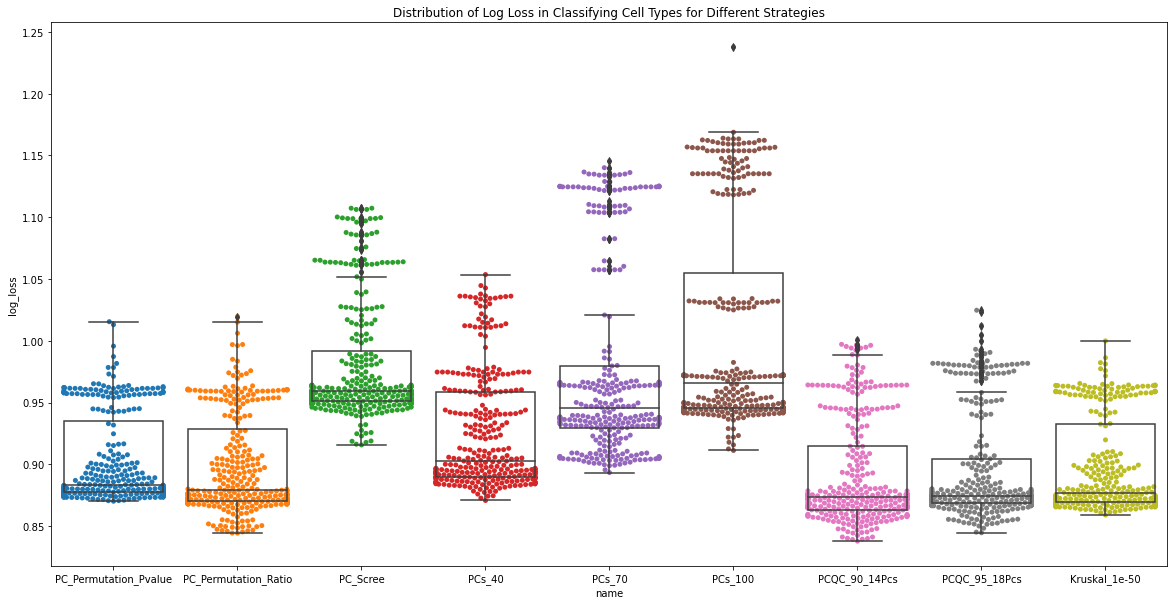

In [70]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss in Classifying Cell Types for Different Strategies')
plot_dictionary['LogLoss'] = plt.gca().get_figure()

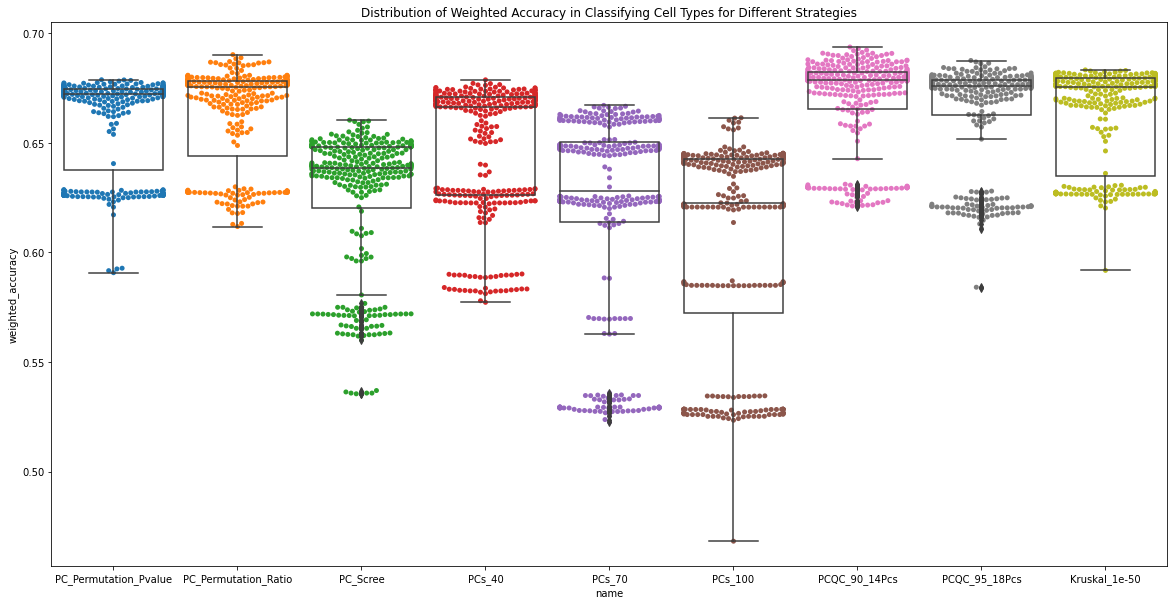

In [71]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'weighted_accuracy', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'weighted_accuracy', data=df_stats, zorder=.5)
plt.title('Distribution of Weighted Accuracy in Classifying Cell Types for Different Strategies')
plot_dictionary['WeightedAccuracy'] = plt.gca().get_figure()

In [72]:
with PdfPages(output_plots) as pdf:
    for title in plot_dictionary.keys():
        pdf.savefig(plot_dictionary[title])

In [73]:
df_stats.groupby(by = ['name']).median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_0,log_loss_cluster_1,log_loss_cluster_2,log_loss_cluster_3,log_loss_cluster_4,log_loss_cluster_5,log_loss_cluster_6,log_loss_cluster_7,log_loss_cluster_8,log_loss_cluster_9,log_loss_cluster_10,log_loss_cluster_11,log_loss_cluster_12,log_loss_cluster_13
name,,,,,,,,,,,,,,,,,,
Kruskal_1e-50,1.0,0.876462,0.624040,0.675618,0.670169,1.283540,1.302194,0.387422,0.741749,1.579826,0.822686,1.310769,0.703306,0.392551,1.121374,0.324753,0.259076,1.420097
PCQC_90_14Pcs,1.0,0.873473,0.626233,0.678710,0.670820,1.279430,1.314113,0.372943,0.732462,1.601644,0.814507,1.264028,0.732088,0.390092,1.071141,0.323490,0.258412,1.435354
PCQC_95_18Pcs,1.0,0.874569,0.627394,0.676100,0.664581,1.273352,1.299964,0.388577,0.753689,1.593368,0.807733,1.277891,0.724248,0.382855,1.105700,0.329957,0.256974,1.417923
PC_Permutation_Pvalue,1.0,0.882854,0.626610,0.672268,0.655064,1.270822,1.293749,0.387579,0.747962,1.593825,0.824286,1.350445,0.702258,0.399988,1.175805,0.320021,0.257849,1.419666
PC_Permutation_Ratio,1.0,0.878841,0.627323,0.675399,0.676928,1.274391,1.290135,0.391709,0.745282,1.595784,0.818858,1.314826,0.735431,0.401816,1.117549,0.319871,0.255140,1.426175
PC_Scree,1.0,0.959078,0.578493,0.638667,0.721674,1.434389,1.462063,0.357356,0.752280,1.735683,0.819317,1.331542,1.407636,0.365096,1.137685,0.318847,0.253706,1.384097
PCs_100,1.0,0.966154,0.575441,0.622345,0.995004,1.277879,1.324590,0.374644,0.763173,1.597423,0.845171,1.427790,0.916690,0.467317,1.367237,0.369630,0.263231,1.538851
PCs_40,1.0,0.902920,0.610088,0.666372,0.794181,1.282565,1.297282,0.366312,0.732315,1.598578,0.808358,1.362914,0.716819,0.429648,1.203124,0.325695,0.259861,1.520172
PCs_70,1.0,0.945295,0.590011,0.627780,0.990366,1.282110,1.305473,0.362591,0.749244,1.590861,0.825447,1.424976,0.823268,0.473964,1.320407,0.321243,0.260557,1.533160


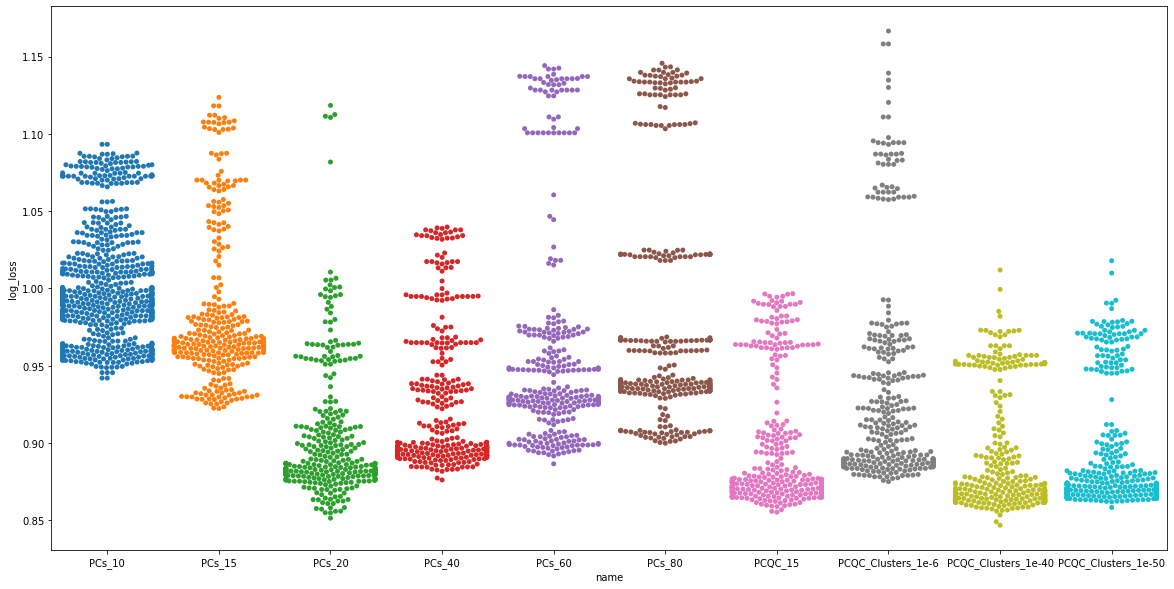

In [402]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.swarmplot(x = 'name', y = 'log_loss', data = df_stats)

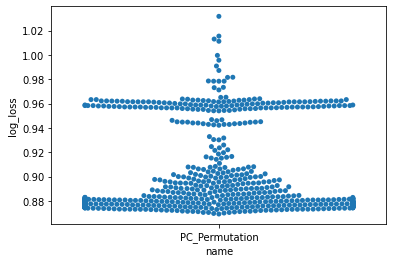

In [23]:
sns.swarmplot(x = 'name', y = 'log_loss', data = df_stats)

### End

In [ ]:
#maximize the linear interpolation of the thresholds


In [ ]:
#could embed a kNN graph for autodetection of elbow.  Set number of neighbors to be 3,5.  
#look for disconnected components

In [ ]:
#sigma scales with mean.  

## Test Example with Multinomial Bayes
Note this isn't naive as no independence assumption is required as there is only one coin flip for each observation.

### Current Metrics Used
1. Log-Loss
2. Weighted Accuracy
3. Average Precision Score (like AUC).  
4. Partial loss analysis, restricting to specific classes.  Filter data to include only interested ground class and then compute log-loss.
***
1. Confusion Matrices
2. For more finetuned analysis which class(es) improved through the parameter/PC selection change. Can restrict analysis to specific columns.  

In [10]:
adata = sc.AnnData(X=cbmc_df.values)

In [123]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

array([ 765,  781,  956, ..., 8584, 8602, 8605])

In [11]:
sc.tl.pca(adata)

In [12]:
sc.pp.neighbors(adata)

In [121]:
?sc.tl.leiden

In [13]:
sc.tl.leiden(adata)

In [32]:
ground_truth['count'] = 1
weights = ground_truth.groupby('leiden')['count'].transform(lambda x: 1/x.count()).values

In [69]:
ground_truth.groupby('leiden')['count'].count()

leiden
0     2313
1     1469
2     1078
3      944
4      693
5      560
6      346
7      313
8      297
9      202
10     197
11     130
12      45
13      30
Name: count, dtype: int64

In [106]:
Bayes = MultinomialNB(fit_prior = False)
Bayes.fit(X,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [108]:
predictions = Bayes.predict_proba(X)

In [109]:
log_loss(y, predictions, sample_weight = weights)

0.9218280499955893

In [107]:
#weighted accuracy
Bayes.score(X,y,sample_weight = weights)

0.6533021955589629

In [110]:
dummies_y = pd.get_dummies(y).values
average_precision_score(dummies_y, predictions, average = 'macro') #micro, macro, weighted

0.5950680563343898

In [111]:
hard_predictions = Bayes.predict(X)

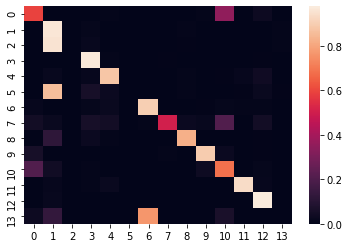

In [112]:
sns.heatmap(confusion_matrix(y, hard_predictions, sample_weight = weights))

In [ ]:
log_loss(y, predictions, sample_weight = weights)

### Predictions with Decision Tree

In [68]:
#will generally perform better on balanced class weight metrics
tree = DecisionTreeClassifier(class_weight='balanced')
X = pd.get_dummies(adata.obs['leiden'])
y = ground_truth['leiden']
tree.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [84]:
tree.get_depth()

16

In [70]:
1/ground_truth.groupby('leiden')['count'].count()

leiden
0     0.000432
1     0.000681
2     0.000928
3     0.001059
4     0.001443
5     0.001786
6     0.002890
7     0.003195
8     0.003367
9     0.004950
10    0.005076
11    0.007692
12    0.022222
13    0.033333
Name: count, dtype: float64

In [71]:
predictions = tree.predict_proba(X)

In [80]:
hard_predictions = tree.predict(X)

In [72]:
tree.score(X,y,sample_weight = weights)

0.6546841841412883

In [75]:
log_loss(y, predictions, sample_weight = weights)

0.8684112582677864

In [ ]:
dummies_y = pd.get_dummies(y).values

In [101]:
average_precision_score(dummies_y, predictions, average = 'macro') #micro, macro, weighted

0.5984282682847886

In [ ]:
#can rerun and collapse on three classes (or four classes if desired)

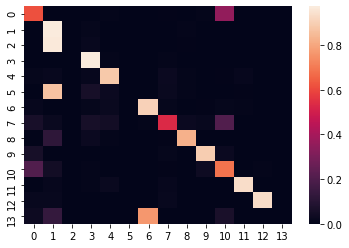

In [81]:
#compute median confusion matrix
sns.heatmap(confusion_matrix(y, hard_predictions, sample_weight = weights))

In [98]:
#suspiciously high
roc_auc_score(dummies_y, predictions, multi_class = 'ovr') #, sample_weight = weights

0.9370519484782106

In [90]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(DecisionTreeClassifier())
classifier.fit(X, y)
predictions = classifier.predict_proba(X)

In [93]:
dummies_y = pd.get_dummies(y).values

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")

In [91]:
log_loss(y, predictions, sample_weight = weights)

1.1340714984778697

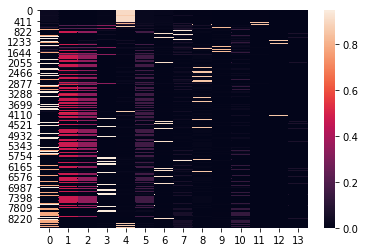

In [27]:
sns.heatmap(predictions)

In [25]:
predictions[900,:]

array([0.00591716, 0.        , 0.        , 0.03550296, 0.00591716,
       0.        , 0.00591716, 0.93491124, 0.        , 0.01183432,
       0.        , 0.        , 0.        , 0.        ])

### Standard Process